In [1]:
from Scripts.essentials import *
import h5py
from natsort import natsorted

Available computational components
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7183810229681546339
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5835325440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7552439797976326313
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [77]:
# Load the data into a dictionary
data_path = "Data/Other/LarionData/ZnSO4x7H2O/"

data = []
data_names = []
for sample in os.listdir(data_path):
    with h5py.File(data_path + sample) as f:
        regions = f["Regions"]
        
        datasets = np.empty((0, 1738))
        for region in list(regions):
            datasets = np.concatenate((datasets, np.nan_to_num(normalize(np.array(regions[region]["Dataset"]).reshape(-1, 1738)))))
            
        data.append(datasets)
        data_names.append(sample)

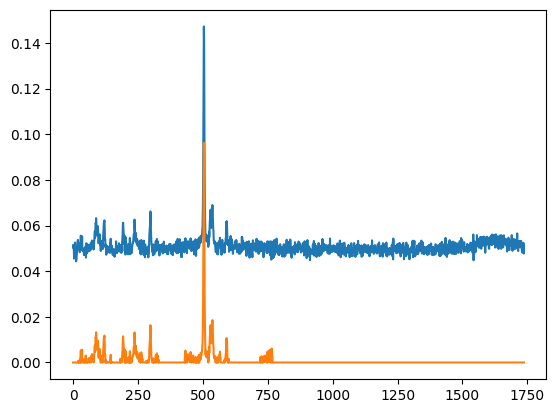

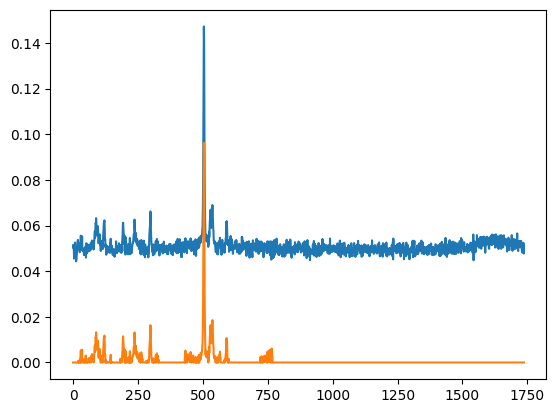

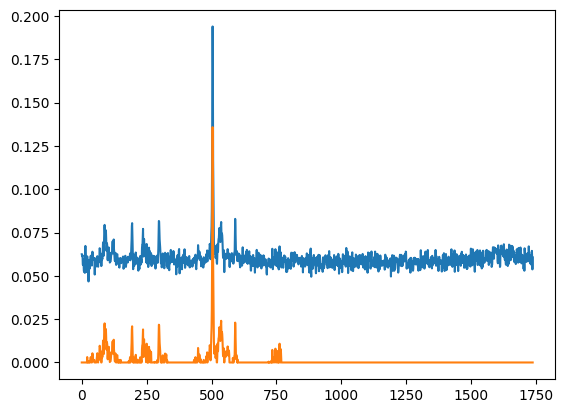

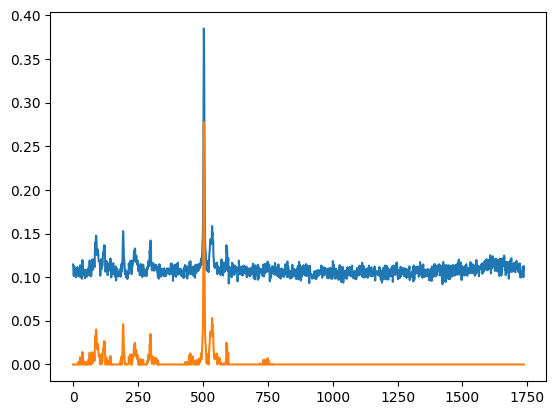

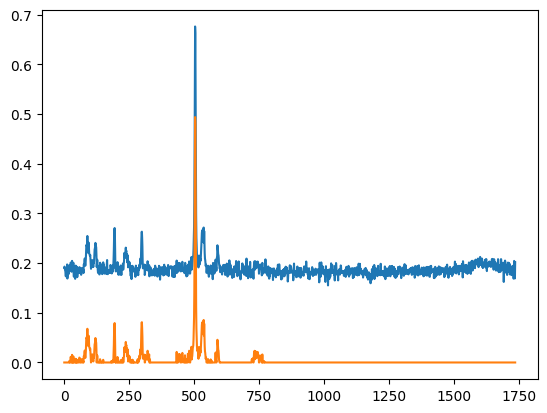

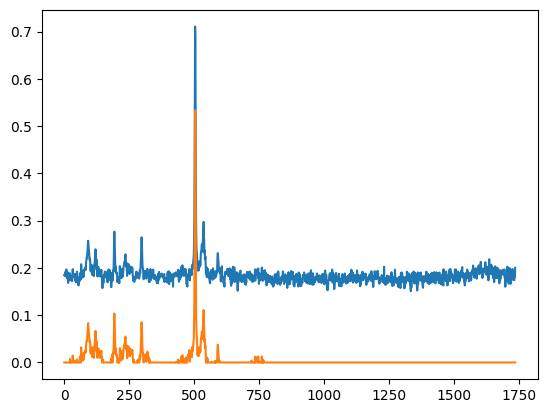

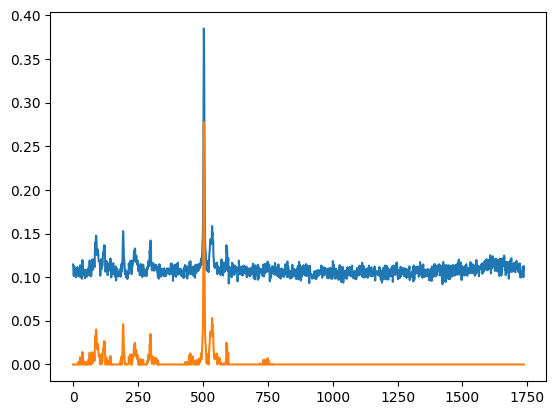

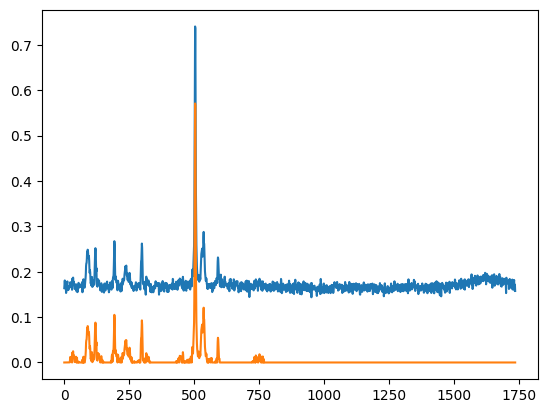

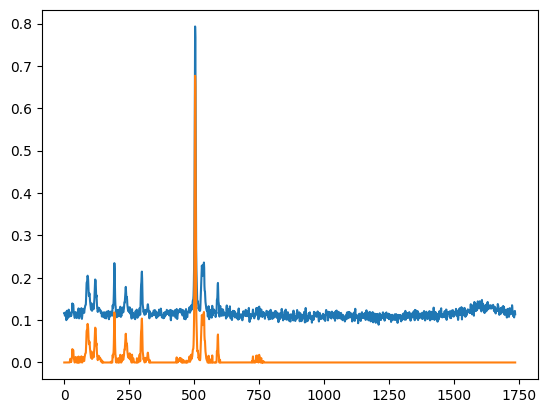

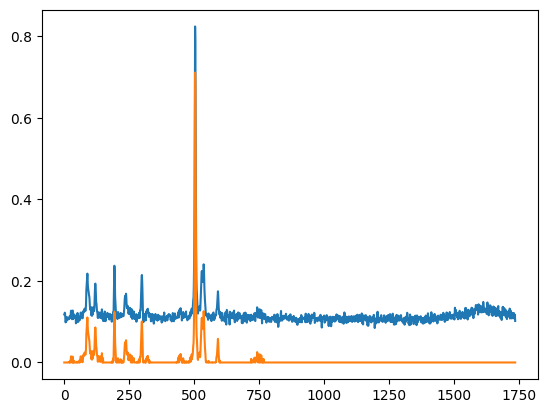

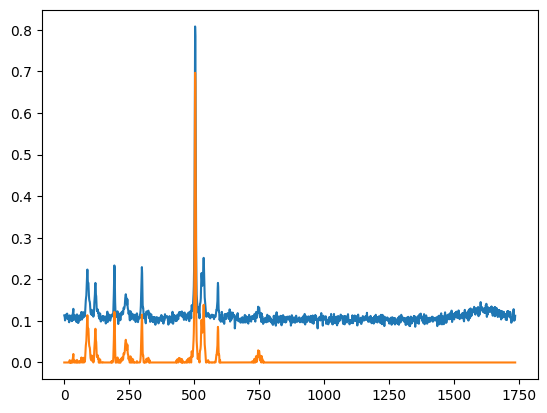

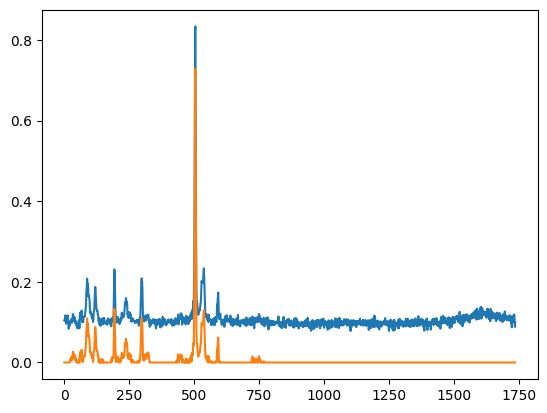

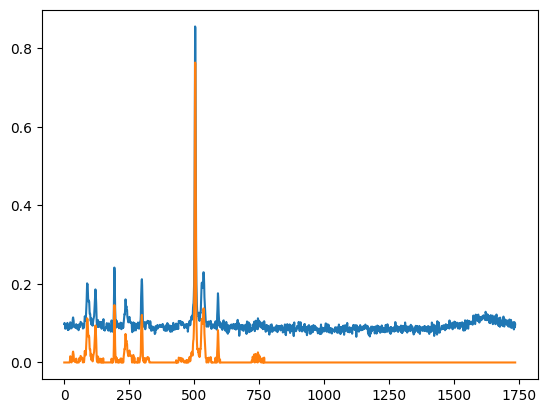

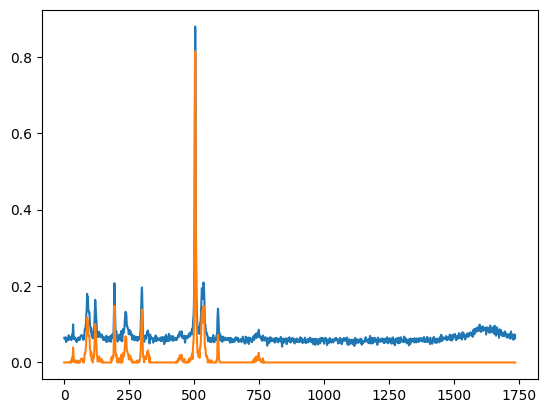

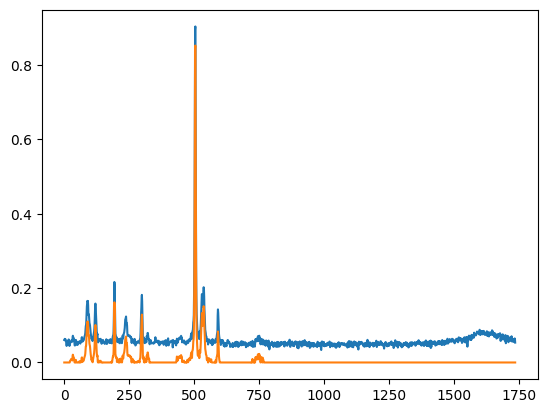

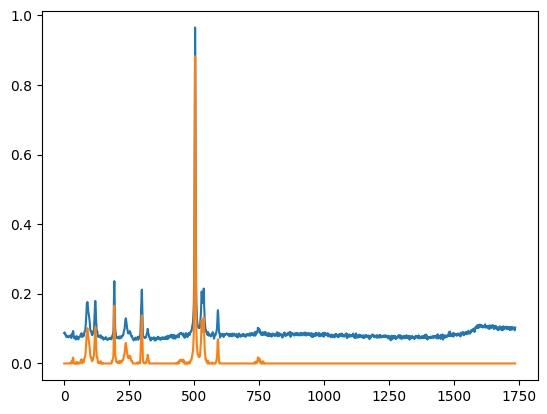

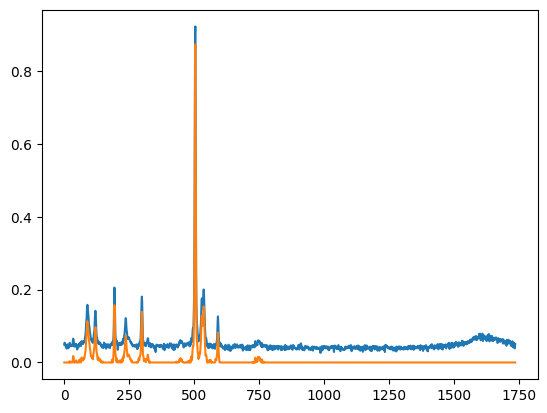

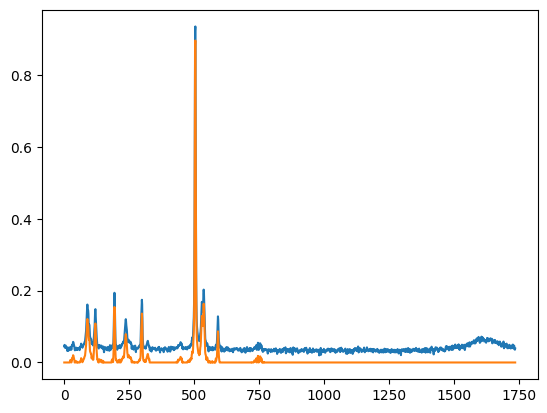

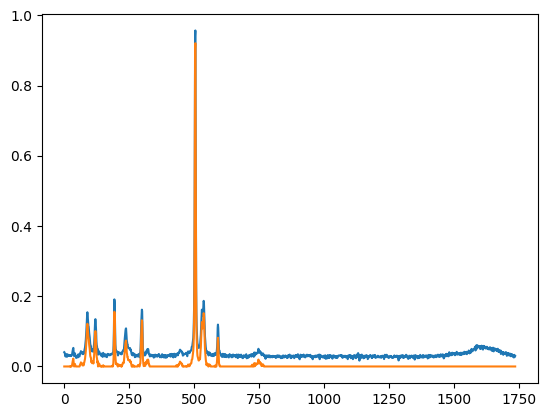

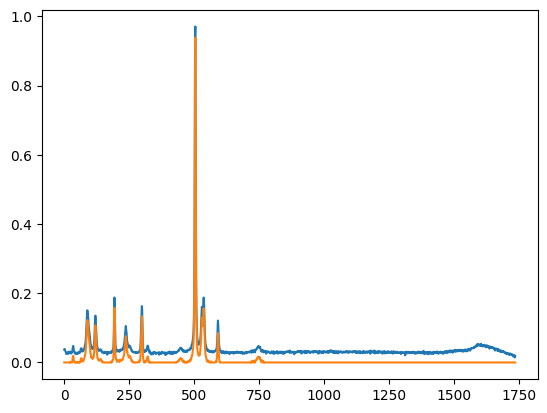

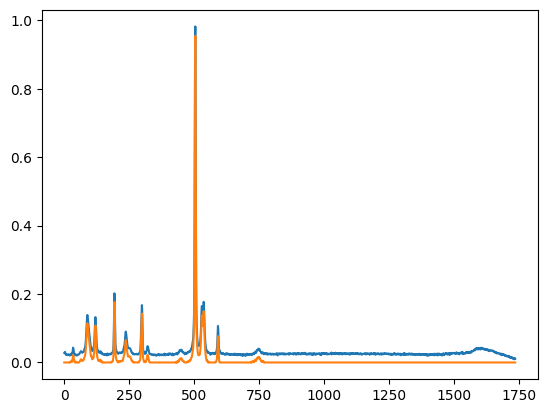

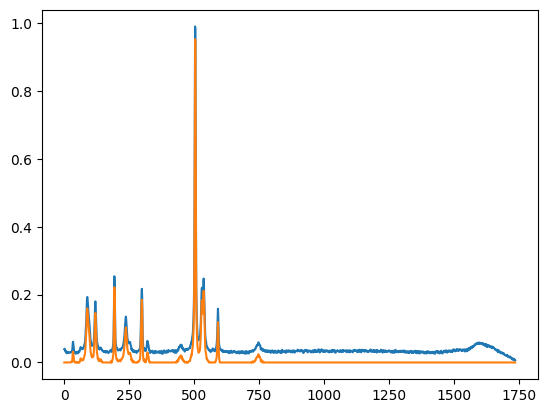

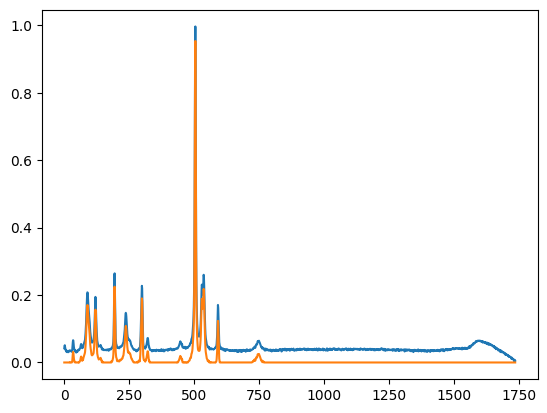

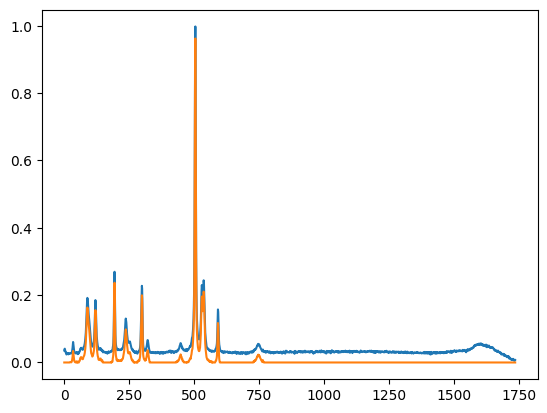

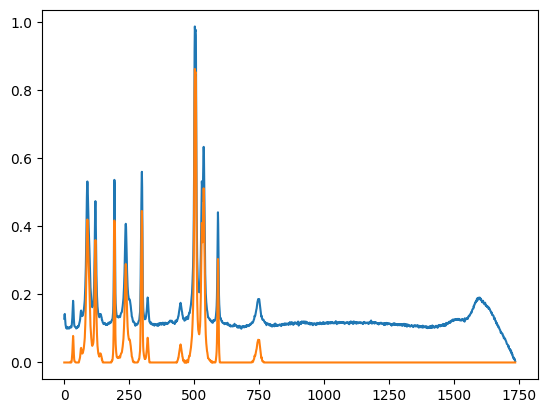

In [3]:
ranges = [[20, 50], [55, 150], [180, 270], [280, 330], [430, 465], [430, 465], [470, 570], [580, 600], [720, 770]]
targets = []
for i in range(len(data)):
    target = np.mean(np.array(np.nan_to_num(data[i])).reshape((-1, 1738)), axis = 0)
    new_target = np.zeros_like(target)
    # Get the peaks
    for r in ranges:
        peak = target[r[0]: r[1] + 1]
    
        
        start = np.median(peak[0:3])
        end = np.median(peak[-3:])
    
        # The baseline at peak location is a linear line between the medians of the left and right ends, estimated by the 10 first and last points
        bl = np.linspace(start, end, r[1] - r[0] + 1, axis = -1)
    
        # Remove the baseline
        new_peak = np.clip(peak - bl, 0, 1)
    
        # Insert the peak
        new_target[r[0]:r[1]+1] = new_peak
    plt.plot(target)
    plt.plot(new_target)
    plt.show()
    
    targets.append(new_target)

In [78]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")

cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")

In [5]:
ensemble_preds = {}
standard_preds = {}

for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d[0].reshape((-1, 1738))

    # Normalization
    maxim = np.max(dn_1, axis = 1)
    minim = np.min(dn_1, axis = 1)
    dn_1 = (dn_1 - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)
        
    denoised_1 = ensemble_model.predict(np.expand_dims(dn_1, -1))[-1]
    denoised_2 = standard_model.predict(np.expand_dims(dn_1, -1))[-1]
    
    ensemble_preds[n] = denoised_1
    standard_preds[n] = denoised_2


ZnSo4heptahydrate0.00167s20umsize50umconfocal600hznotsqare.h5
88/88 [==============================] - 23s 252ms/step
ZnSo4heptahydrate0.00167s20umsize50umconfocal600hzonly1spot.h5
88/88 [==============================] - 22s 251ms/step
ZnSo4heptahydrate0.00174s20umsize50umconfocal575hz.h5
13/13 [==============================] - 3s 270ms/step
ZnSo4heptahydrate0.00190s20umsize50umconfocal525hz.h5
13/13 [==============================] - 3s 255ms/step
ZnSo4heptahydrate0.0025s20umsize50umconfocal400hz.h5
13/13 [==============================] - 3s 70ms/step
ZnSo4heptahydrate0.00286s20umsize50umconfocal350hz.h5
13/13 [==============================] - 3s 256ms/step
ZnSo4heptahydrate0.002s20umsize50umconfocal500hz.h5
13/13 [==============================] - 3s 257ms/step
ZnSo4heptahydrate0.00333s20umsize50umconfocal300hz.h5
13/13 [==============================] - 3s 255ms/step
ZnSo4heptahydrate0.00417s20umsize50umconfocal240hz.h5
13/13 [==============================] - 3s 255ms/step
ZnSo

In [6]:

casc_preds = {}
for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d[0].reshape((-1, 1738)) * 1000
        
        # Model is designed for spectrum length 1024, split the spectrum in half 
    denoised_1 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, :1024], -1))[-1]/1000)
    denoised_2 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, -1024 :], -1))[-1]/1000)
        
        #Join the predictions in the middle
    denoised = np.hstack((denoised_1[:, :1738 - 1024], denoised_2))
        
    casc_preds[n] = denoised

ZnSo4heptahydrate0.00167s20umsize50umconfocal600hznotsqare.h5
88/88 [==============================] - 23s 265ms/step
ZnSo4heptahydrate0.00167s20umsize50umconfocal600hzonly1spot.h5
88/88 [==============================] - 16s 187ms/step
ZnSo4heptahydrate0.00174s20umsize50umconfocal575hz.h5
13/13 [==============================] - 3s 271ms/step
ZnSo4heptahydrate0.00190s20umsize50umconfocal525hz.h5
13/13 [==============================] - 3s 270ms/step
ZnSo4heptahydrate0.0025s20umsize50umconfocal400hz.h5
13/13 [==============================] - 3s 271ms/step
ZnSo4heptahydrate0.00286s20umsize50umconfocal350hz.h5
13/13 [==============================] - 3s 270ms/step
ZnSo4heptahydrate0.002s20umsize50umconfocal500hz.h5
13/13 [==============================] - 3s 270ms/step
ZnSo4heptahydrate0.00333s20umsize50umconfocal300hz.h5
13/13 [==============================] - 3s 272ms/step
ZnSo4heptahydrate0.00417s20umsize50umconfocal240hz.h5
13/13 [==============================] - 3s 271ms/step
ZnS

In [8]:
names = ["Ensemble", "Standard", "Kazemzadeh et al."]
metrics = []
for data_name, new_target in zip(data_names, targets):
    metrics.append([])
    
    print(data_name)
    names_ix = 0
    for p in [ensemble_preds, standard_preds, casc_preds]:

        maxim = np.max(new_target)
        #m = np.sqrt(np.mean(np.power(new_target/maxim - np.nan_to_num(p[data_name]/maxim), 2)))
        m = np.max(np.abs(new_target/maxim - np.nan_to_num(p[data_name]/maxim)))
        print(m)
        metrics[-1].append(m)
        names_ix += 1
    
metrics = np.array(metrics)
exp_times = []
for data_name in data_names:
    t = float(data_name[len("ZnSo4heptahydrate"): len("ZnSo4heptahydrate") + data_name[len("ZnSo4heptahydrate"):].find("s")])
    exp_times.append(t)
exp_times = np.array(exp_times)
sorting = np.argsort(exp_times)

exp_times = exp_times[sorting]
metrics = metrics[sorting]

ZnSo4heptahydrate0.00167s20umsize50umconfocal600hznotsqare.h5
9.544805
7.673945
8.857107
ZnSo4heptahydrate0.00167s20umsize50umconfocal600hzonly1spot.h5
9.544805
7.673945
8.857107
ZnSo4heptahydrate0.00174s20umsize50umconfocal575hz.h5
6.106347
4.9651127
5.9981256
ZnSo4heptahydrate0.00190s20umsize50umconfocal525hz.h5
2.9878218
2.1316054
2.8295257
ZnSo4heptahydrate0.0025s20umsize50umconfocal400hz.h5
1.8996495
1.5516655
1.4255352
ZnSo4heptahydrate0.00286s20umsize50umconfocal350hz.h5
1.6547817
1.2123083
1.367355
ZnSo4heptahydrate0.002s20umsize50umconfocal500hz.h5
2.9878218
2.1316054
2.8295257
ZnSo4heptahydrate0.00333s20umsize50umconfocal300hz.h5
1.4900626
1.0340395
1.2569662
ZnSo4heptahydrate0.00417s20umsize50umconfocal240hz.h5
1.2895169
0.8889741
0.9930547
ZnSo4heptahydrate0.00455s20umsize50umconfocal220hz.h5
1.2956511
0.88706535
0.994194
ZnSo4heptahydrate0.005s20umsize50umconfocal200hz.h5
1.1895789
0.82820404
0.99498534
ZnSo4heptahydrate0.00625s20umsize50umconfocal160hz.h5
1.2014314
0.9751

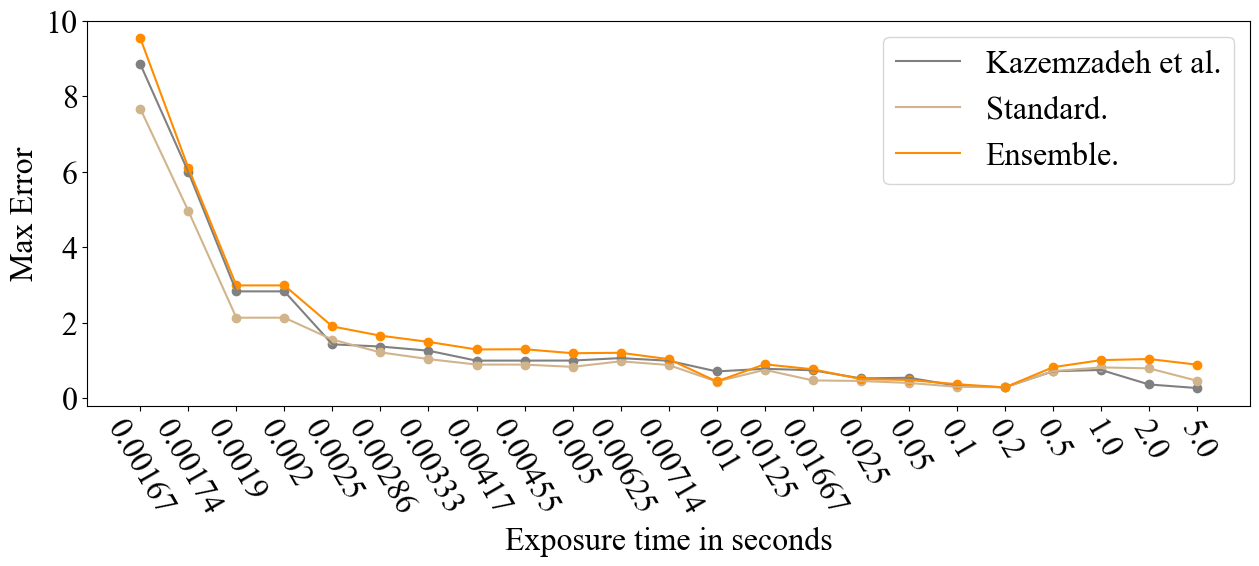

In [9]:
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize = (15, 5))

plt.plot(metrics[1:-1, 2], color = "gray", label = "Kazemzadeh et al.")
plt.scatter(np.arange(len(metrics[1:-1])), metrics[1:-1, 2], color = "gray")

plt.plot(metrics[1:-1, 1], color = "tan", label = "Standard.")
plt.scatter(np.arange(len(metrics[1:-1])), metrics[1:-1, 1], color = "tan")

plt.plot(metrics[1:-1, 0], color = "darkorange", label = "Ensemble.")
plt.scatter(np.arange(len(metrics[1:-1])), metrics[1:-1, 0], color = "darkorange")

plt.xticks(np.arange(len(exp_times[1:-1])), exp_times[1:-1], rotation = -60)

plt.xlabel("Exposure time in seconds")
#plt.ylabel("RMSE")
plt.ylabel("Max Error")
plt.legend()
plt.savefig("Figures/ZnSO4x7H2OExposureTimeReduction.png",
                   bbox_inches='tight', pad_inches=0.75)
plt.show()

ZnSo4heptahydrate0.00167s20umsize50umconfocal600hznotsqare.h5
[0.002 0.002 0.003 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.058 0.06  0.058 ... 0.038 0.039 0.048]


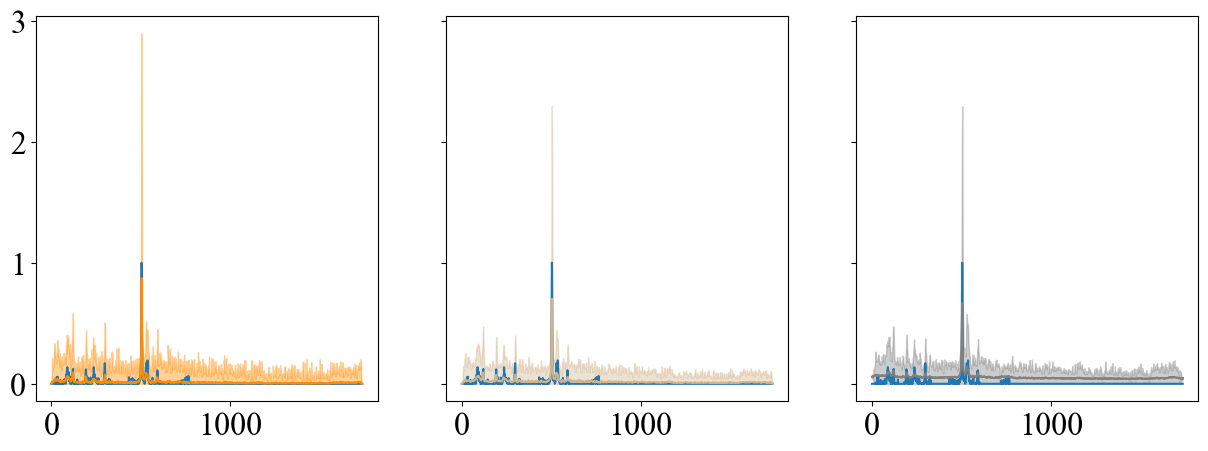

ZnSo4heptahydrate0.00167s20umsize50umconfocal600hzonly1spot.h5
[0.002 0.002 0.003 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.058 0.06  0.058 ... 0.038 0.039 0.048]


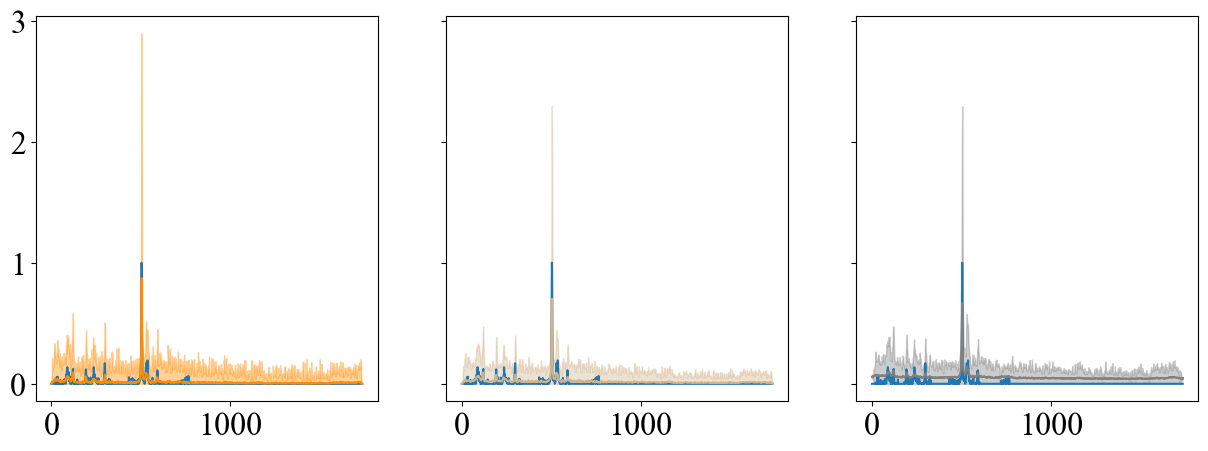

ZnSo4heptahydrate0.00174s20umsize50umconfocal575hz.h5
[0.002 0.001 0.005 ... 0.    0.    0.   ]
[0.    0.    0.001 ... 0.    0.    0.   ]
[0.041 0.043 0.041 ... 0.027 0.028 0.034]


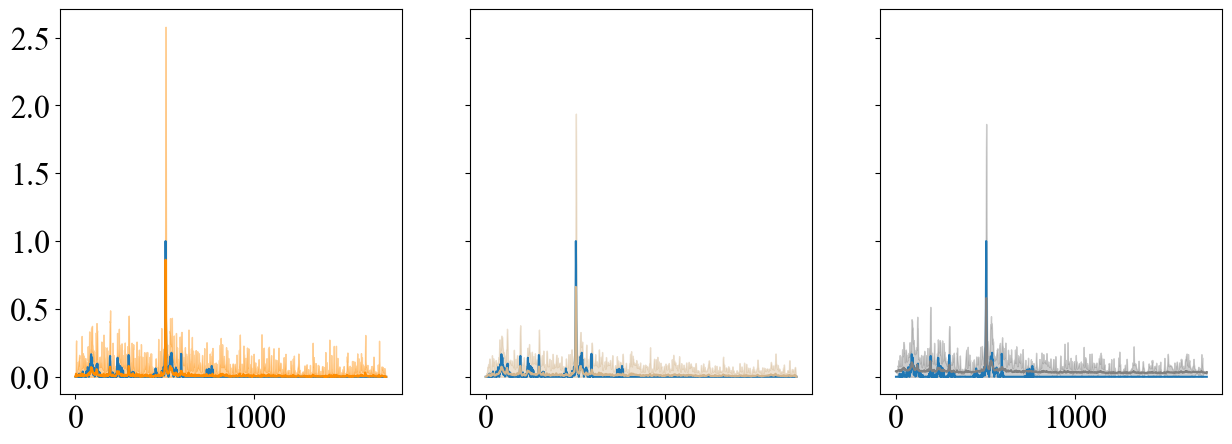

ZnSo4heptahydrate0.00190s20umsize50umconfocal525hz.h5
[0.005 0.004 0.005 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.021 0.021 0.021 ... 0.013 0.014 0.016]


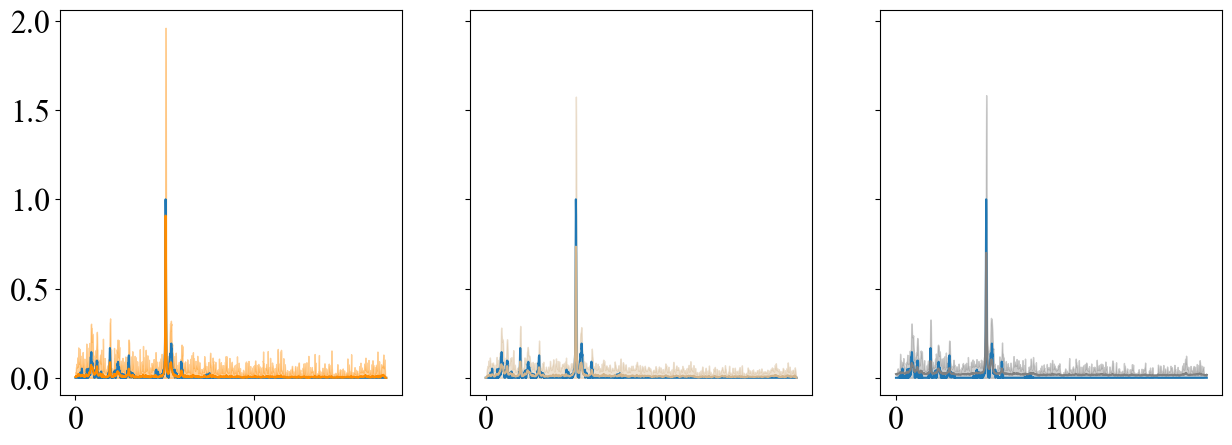

ZnSo4heptahydrate0.0025s20umsize50umconfocal400hz.h5
[0.004 0.003 0.004 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.012 0.012 0.012 ... 0.008 0.008 0.009]


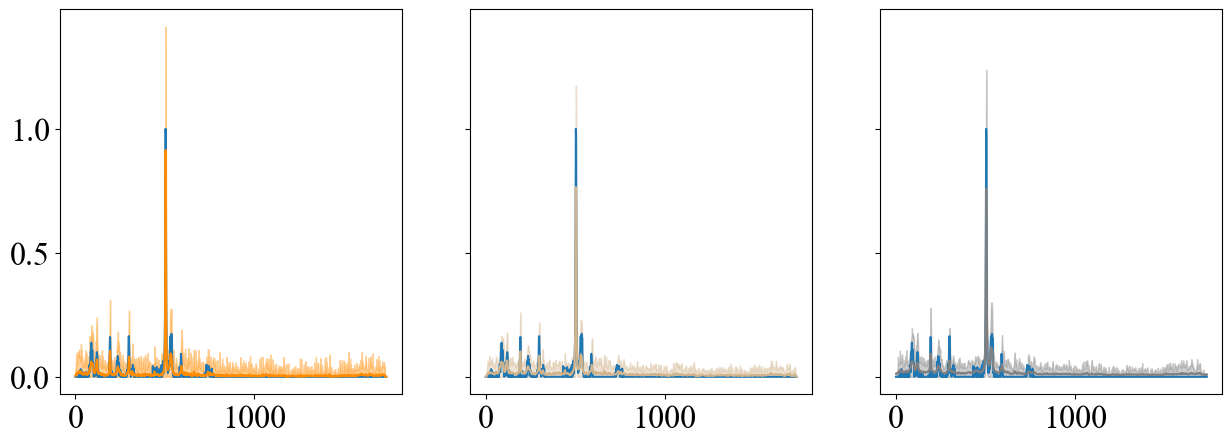

ZnSo4heptahydrate0.00286s20umsize50umconfocal350hz.h5
[0.003 0.002 0.004 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.012 0.012 0.012 ... 0.007 0.007 0.008]


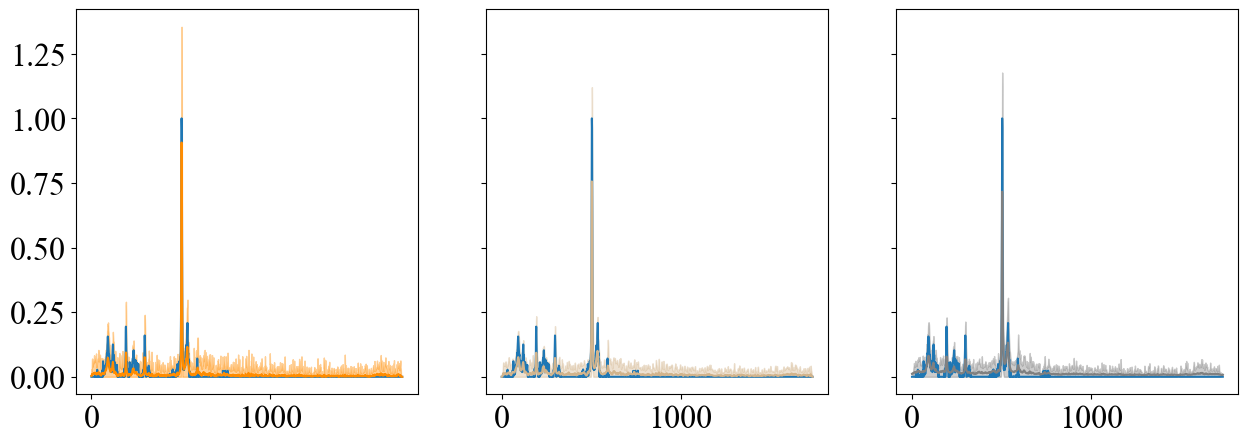

ZnSo4heptahydrate0.002s20umsize50umconfocal500hz.h5
[0.005 0.004 0.005 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.021 0.021 0.021 ... 0.013 0.014 0.016]


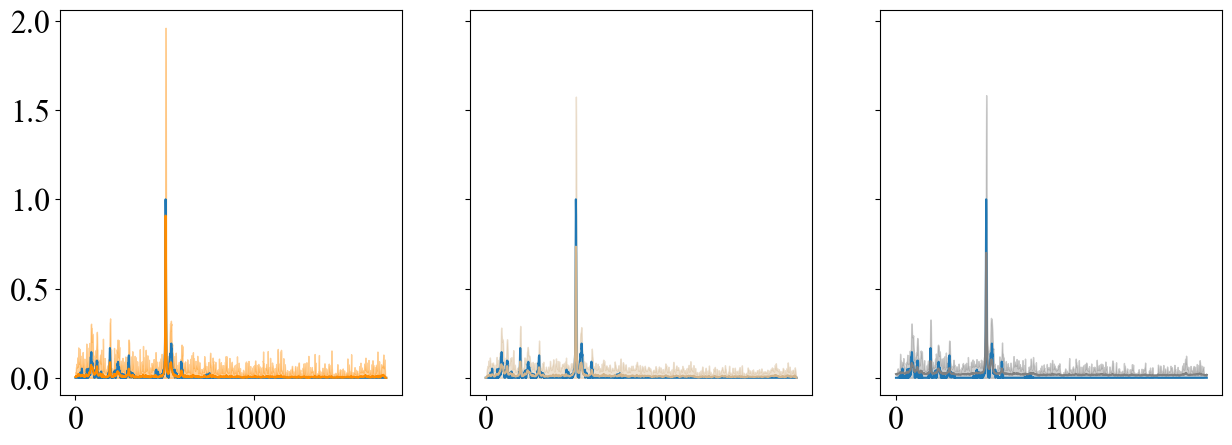

ZnSo4heptahydrate0.00333s20umsize50umconfocal300hz.h5
[0.002 0.002 0.003 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.011 0.011 0.011 ... 0.007 0.007 0.008]


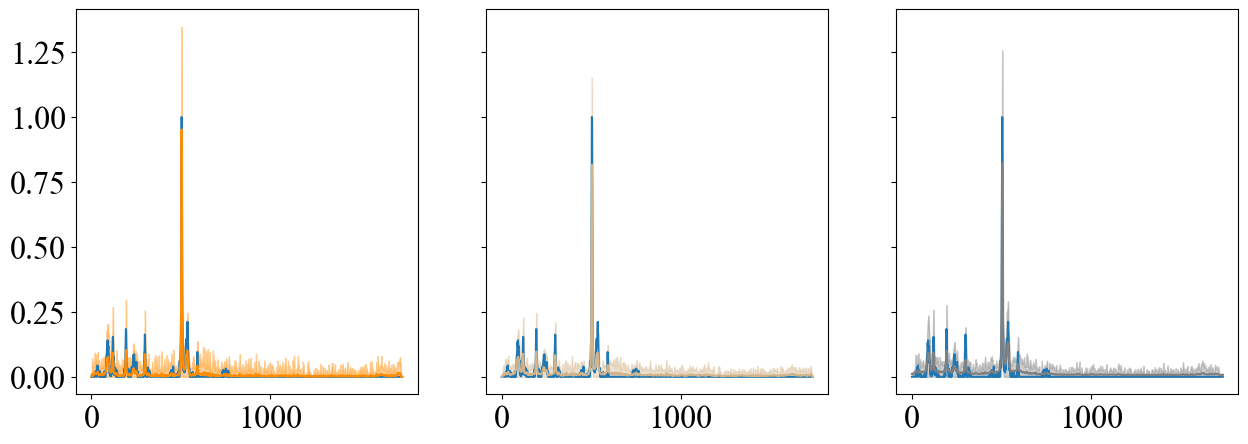

ZnSo4heptahydrate0.00417s20umsize50umconfocal240hz.h5
[0.002 0.002 0.003 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.01  0.01  0.01  ... 0.005 0.006 0.007]


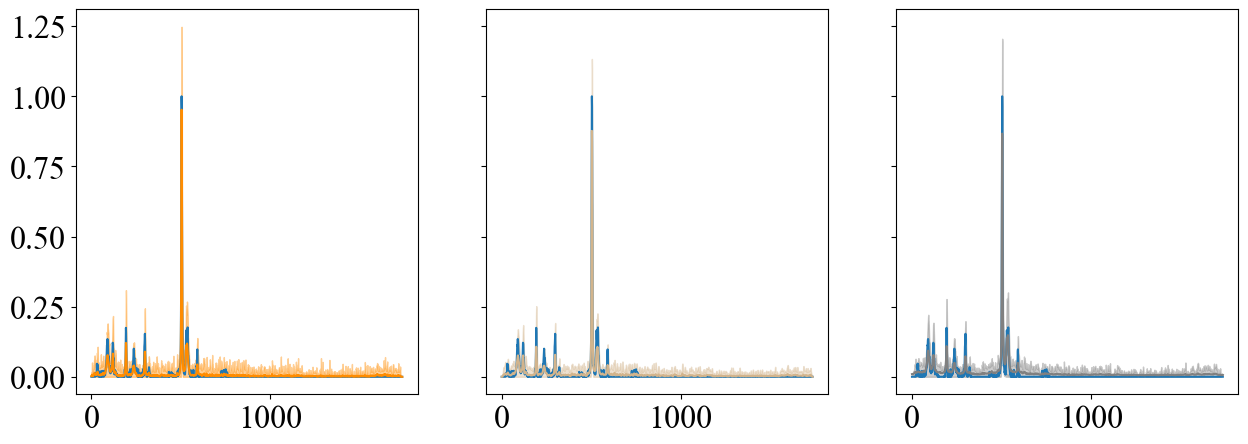

ZnSo4heptahydrate0.00455s20umsize50umconfocal220hz.h5
[0.002 0.001 0.002 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.009 ... 0.005 0.005 0.006]


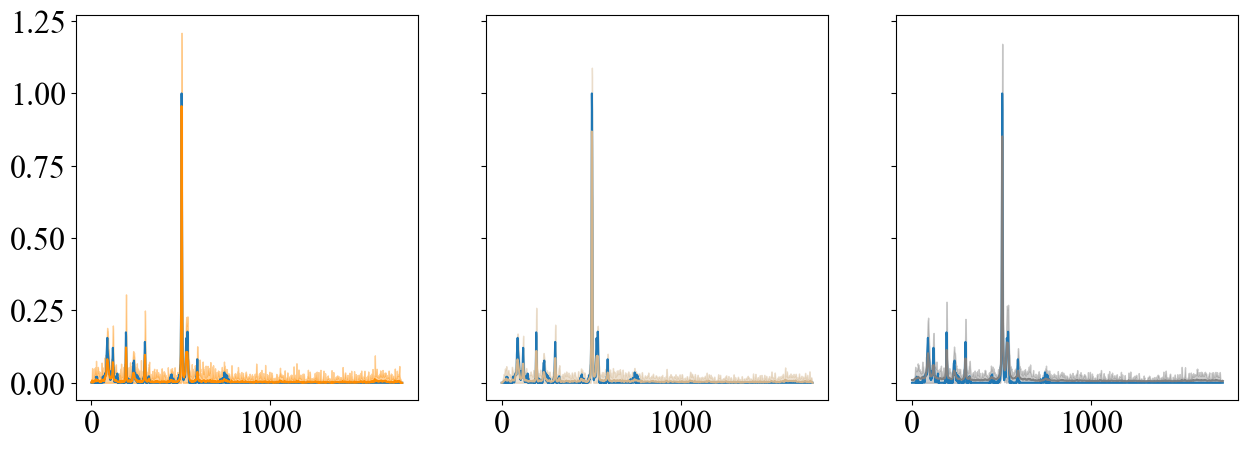

ZnSo4heptahydrate0.005s20umsize50umconfocal200hz.h5
[0.001 0.001 0.001 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.01  0.01  0.01  ... 0.005 0.006 0.007]


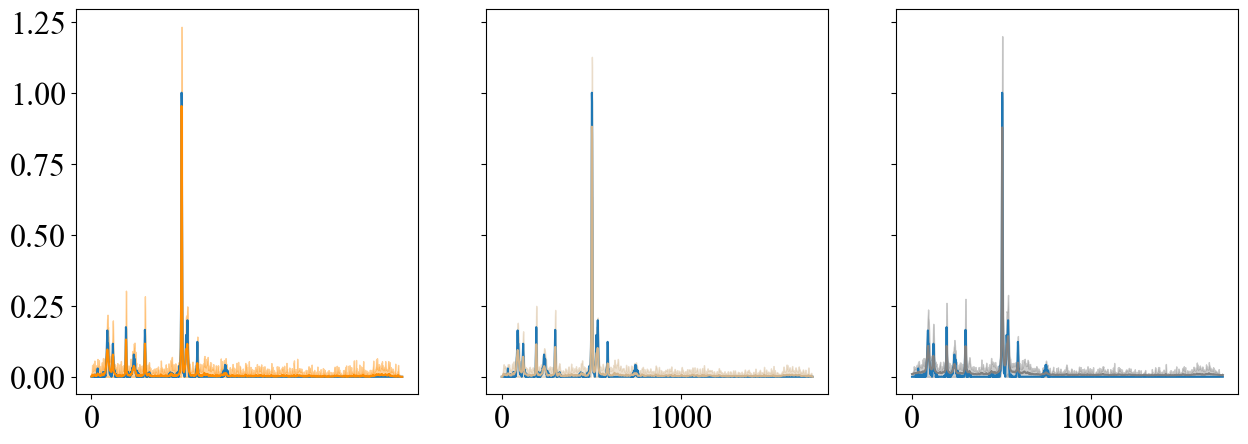

ZnSo4heptahydrate0.00625s20umsize50umconfocal160hz.h5
[0.001 0.001 0.002 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.01  ... 0.005 0.005 0.006]


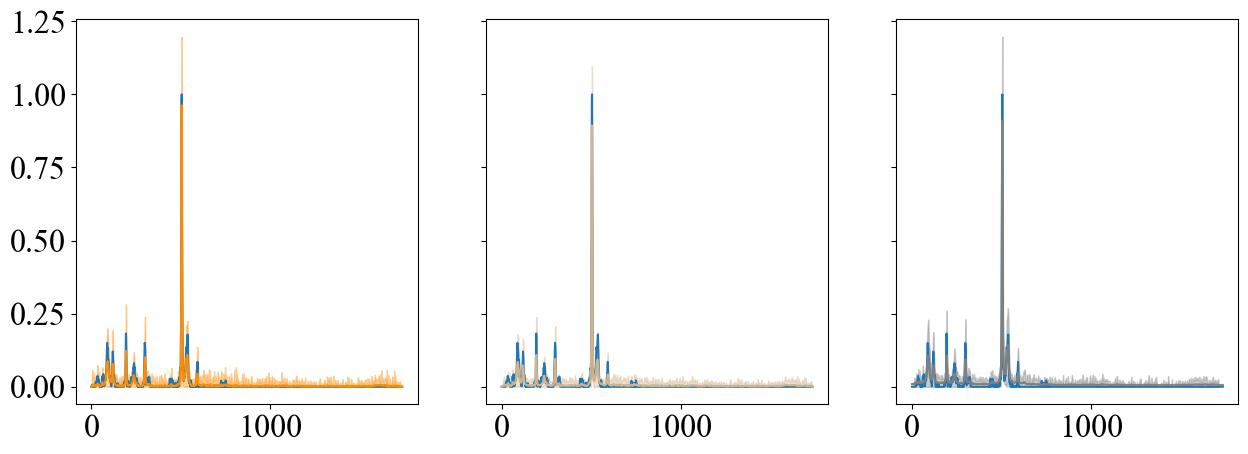

ZnSo4heptahydrate0.00714s20umsize50umconfocal140hz.h5
[0.001 0.001 0.002 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.009 ... 0.005 0.005 0.006]


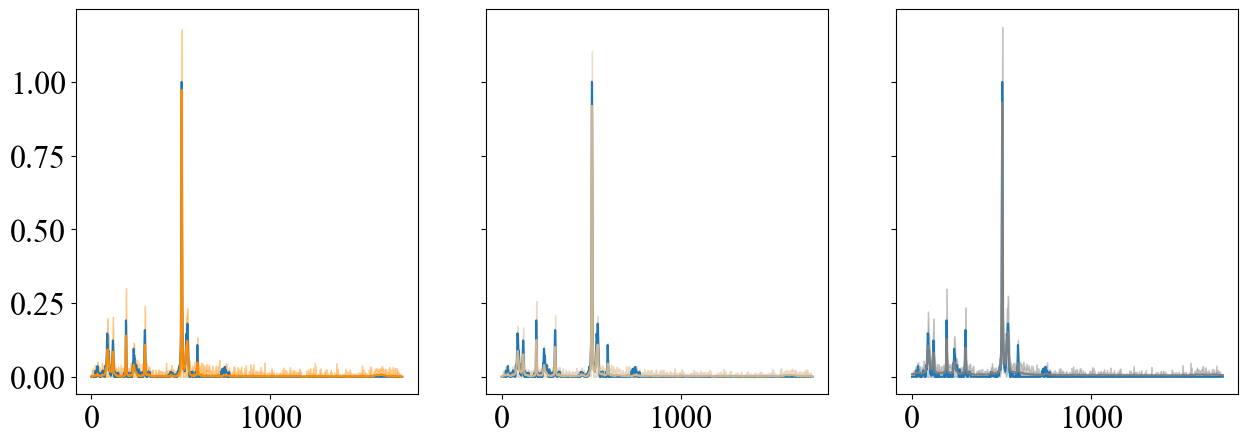

ZnSo4heptahydrate0.0125s20umsize50umconfocal80hz.h5
[0.001 0.001 0.001 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.008 0.009 0.009 ... 0.004 0.005 0.005]


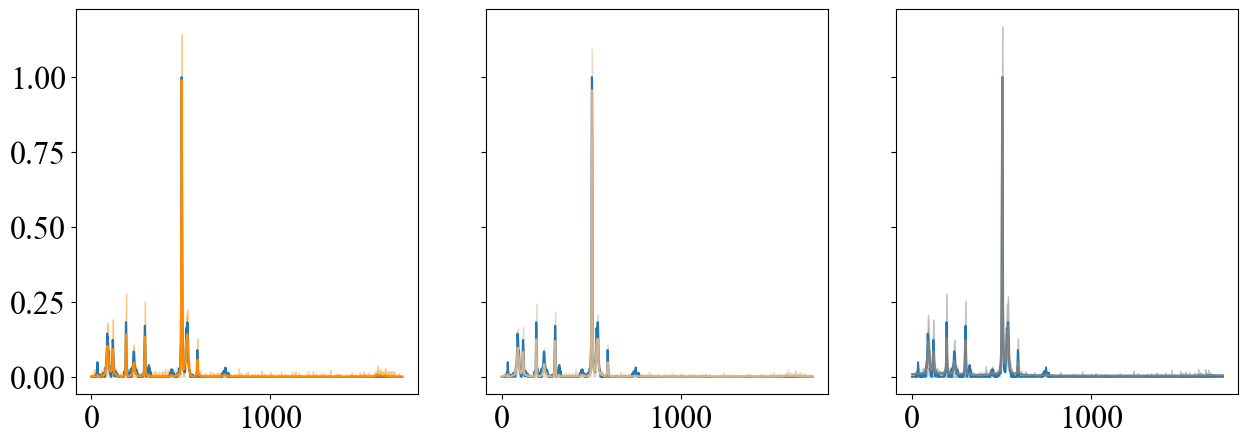

ZnSo4heptahydrate0.01667s20umsize50umconfocal60hz.h5
[0.001 0.001 0.001 ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0.008 0.009 0.009 ... 0.004 0.004 0.005]


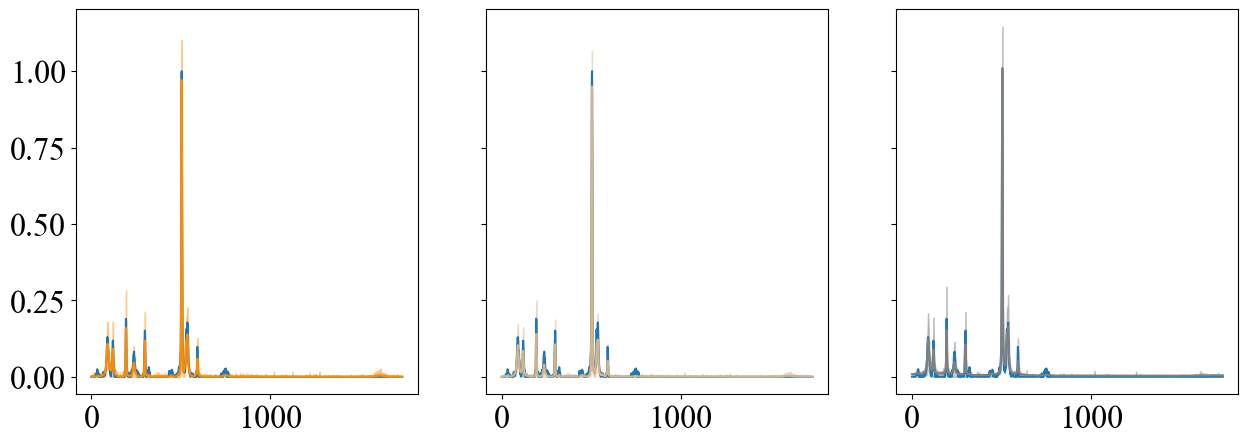

ZnSo4heptahydrate0.01s20umsize50umconfocal100hzredone2.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.008 0.009 0.009 ... 0.004 0.004 0.005]


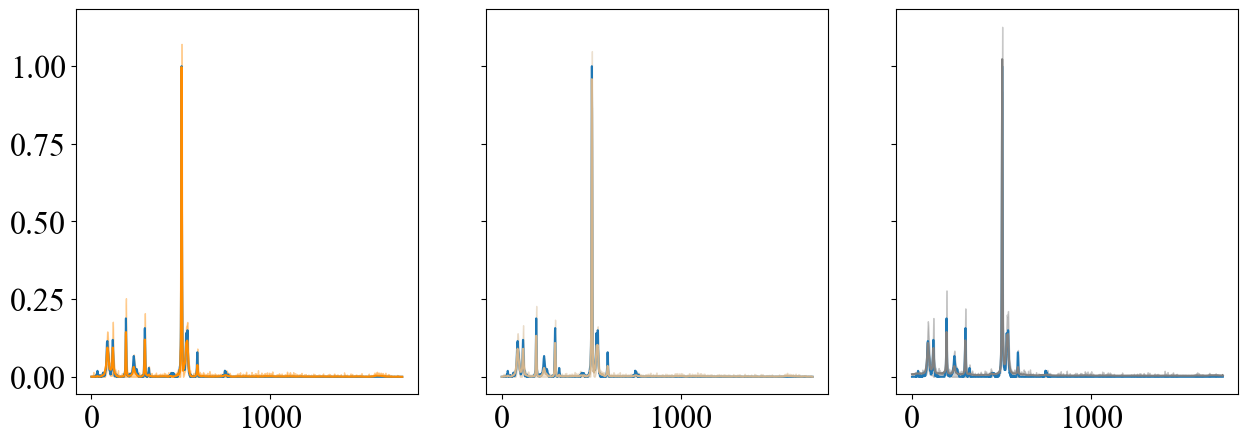

ZnSo4heptahydrate0.025s20umsize50umconfocal40hz.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.008 0.009 0.009 ... 0.004 0.004 0.005]


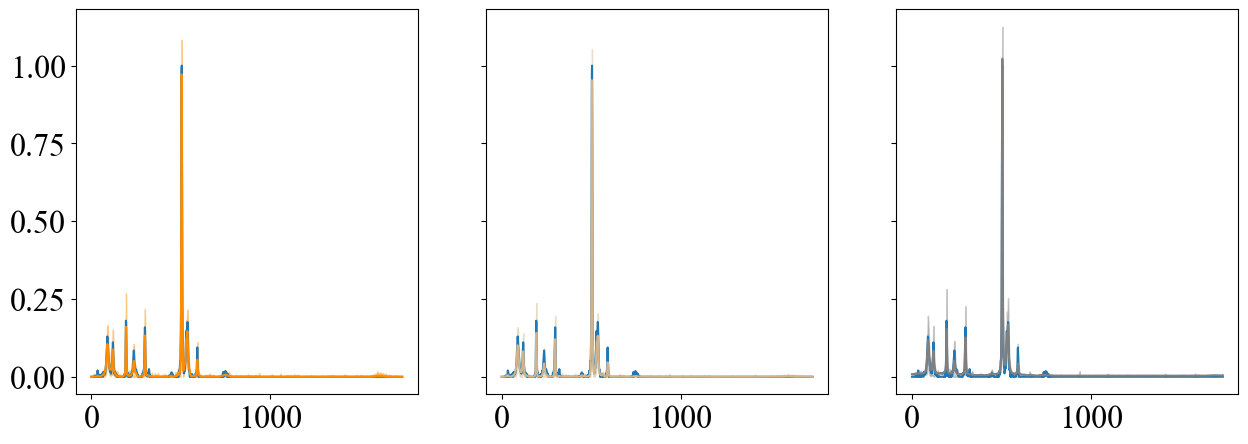

ZnSo4heptahydrate0.05s20umsize50umconfocal20hz.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.009 ... 0.004 0.004 0.005]


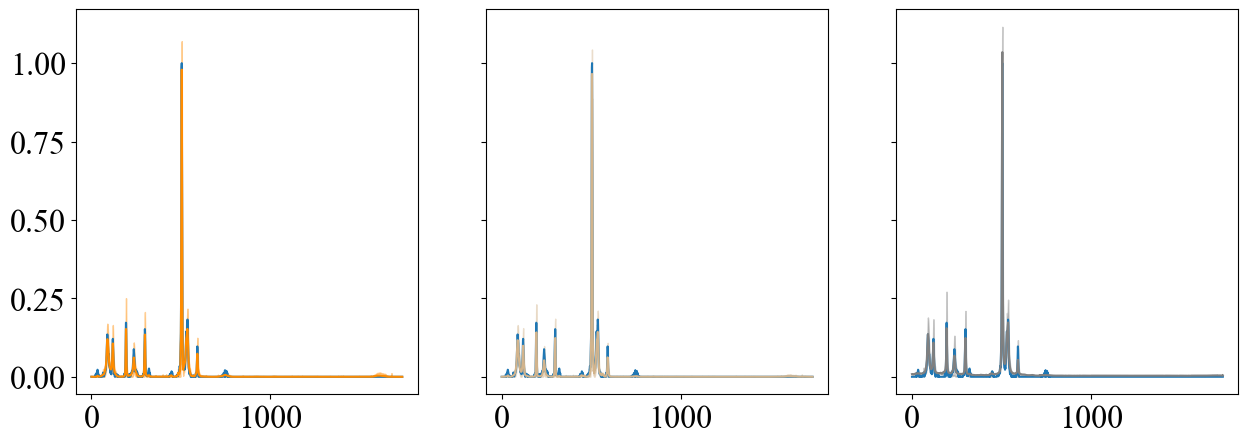

ZnSo4heptahydrate0.1s20umsize50umconfocal10hz.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.009 ... 0.003 0.004 0.005]


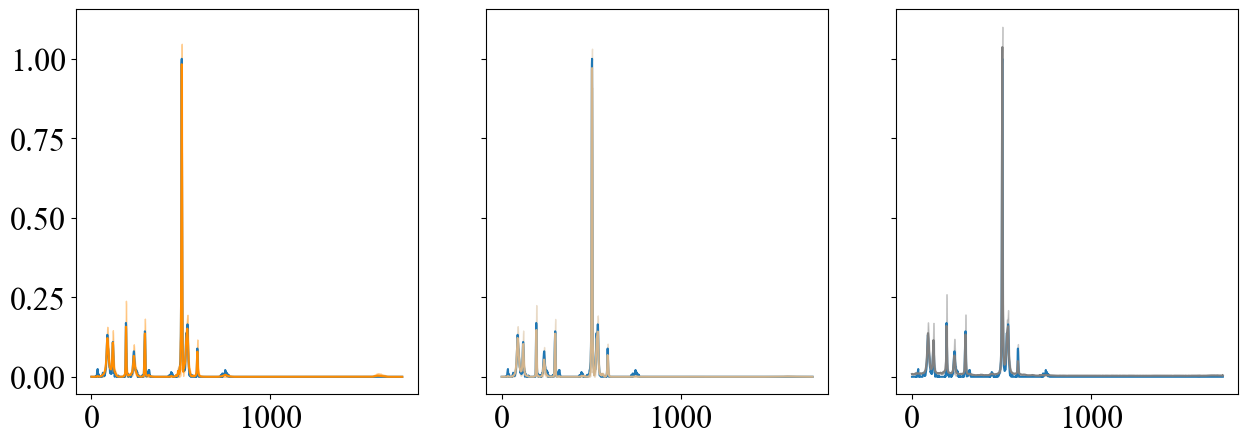

ZnSo4heptahydrate0.2s20umsize50umconfocal5hz.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.008 0.009 0.008 ... 0.003 0.004 0.005]


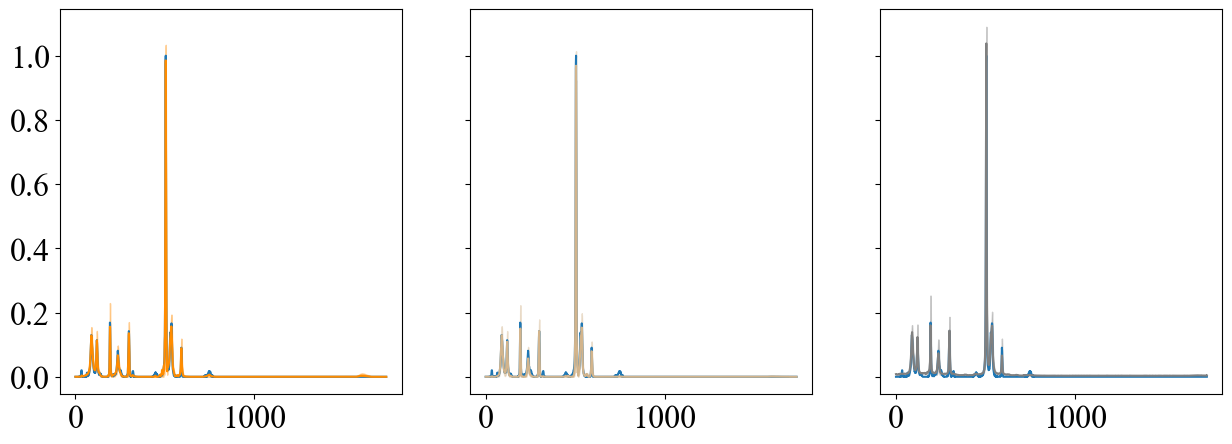

ZnSo4heptahydrate0.5s20umsize50umconfocal2hz.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.008 ... 0.003 0.004 0.005]


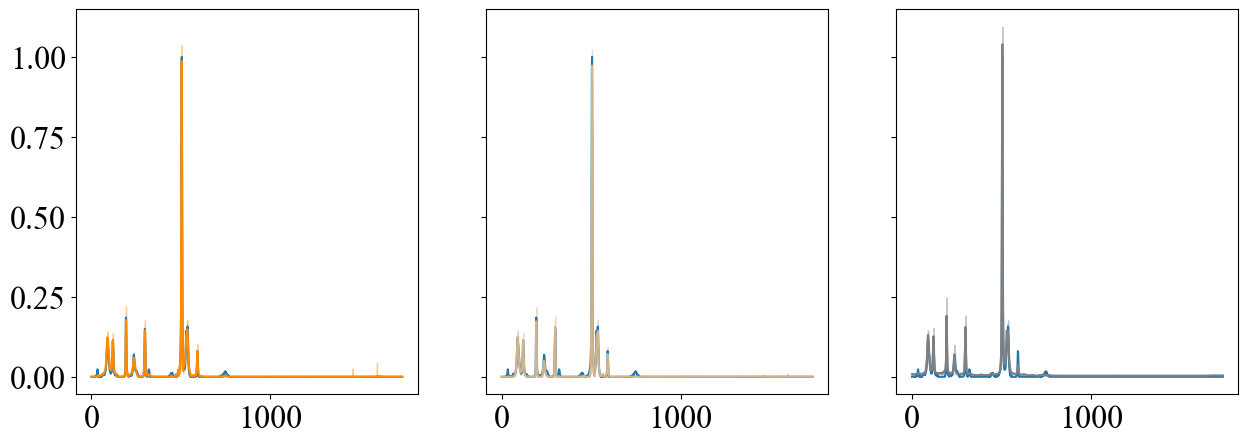

ZnSo4heptahydrate1s20umsize50umconfocal1hzredone.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.008 ... 0.003 0.004 0.005]


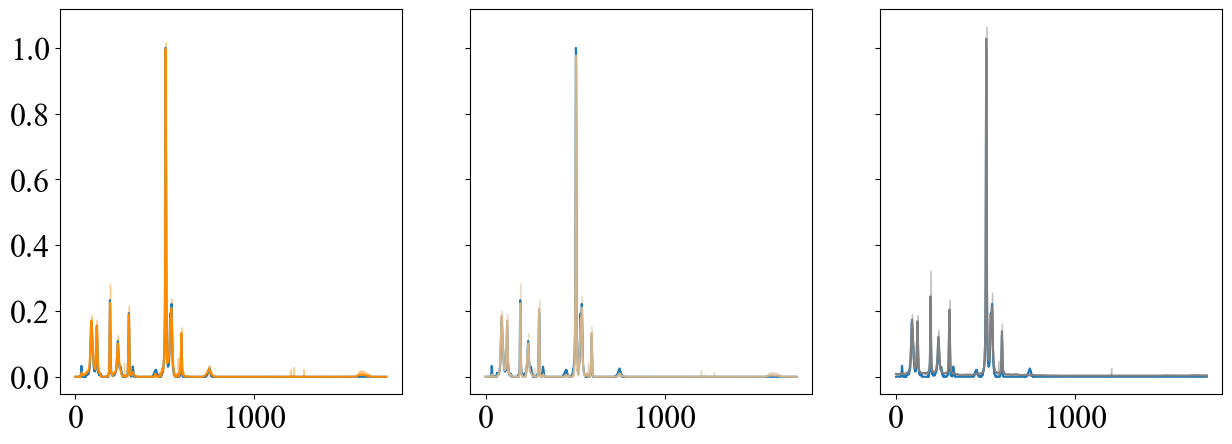

ZnSo4heptahydrate2s20umsize50umconfocal0.5hzredone.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.01  0.008 ... 0.003 0.004 0.005]


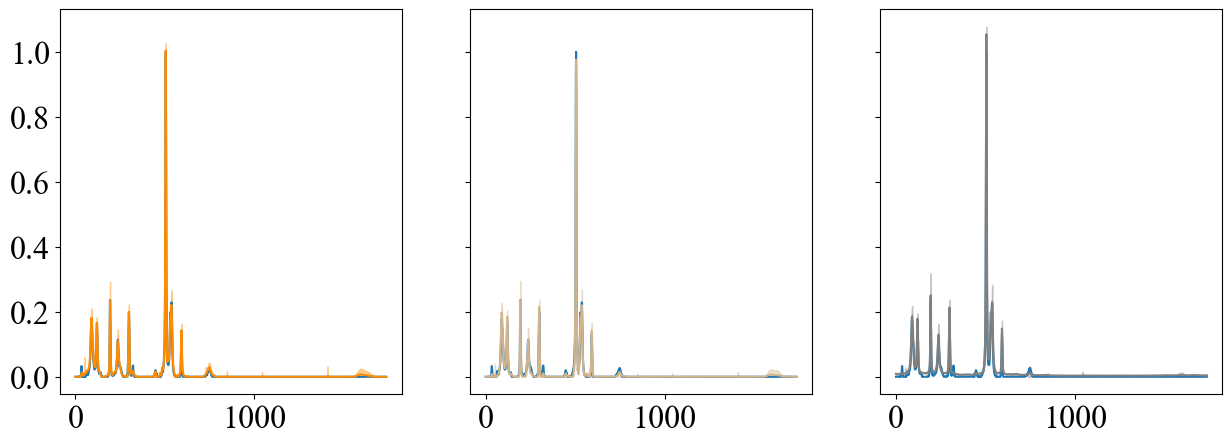

ZnSo4heptahydrate5s20umsize50umconfocal0.2hz.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.009 0.009 0.008 ... 0.003 0.004 0.005]


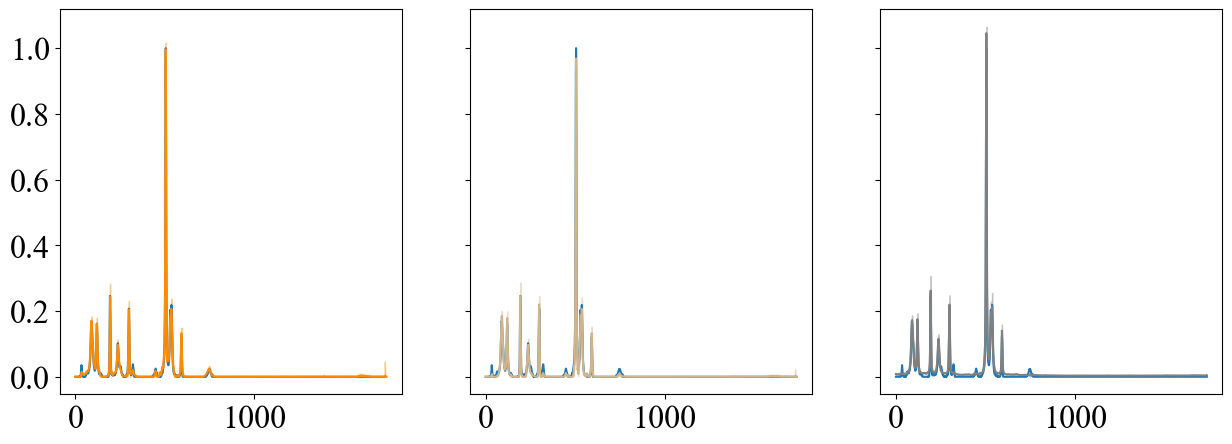

ZnSo4heptahydrate5s20umsize50umconfocal0.2hzonlyrightside.h5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.013 0.013 0.012 ... 0.007 0.006 0.007]


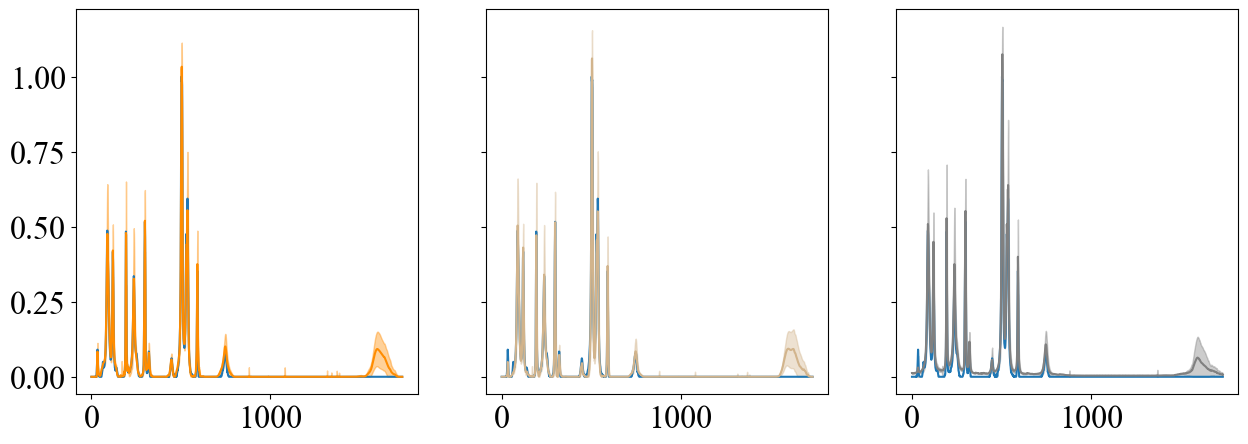

In [10]:
for t, n in zip(targets, data_names):
    
    maxim = np.max(t)
    print(n)
    fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
    
    ax[0].plot(t/maxim)
    mean = np.mean(np.nan_to_num(ensemble_preds[n])/maxim, axis = 0)
    std = np.std(np.nan_to_num(ensemble_preds[n])/maxim, axis = 0)
    print(mean)
    ax[0].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "darkorange", alpha = 0.4)
    ax[0].plot(mean, color = "darkorange")

    
    ax[1].plot(t/maxim)
    mean = np.mean(np.nan_to_num(standard_preds[n])/maxim, axis = 0)
    std = np.std(np.nan_to_num(standard_preds[n])/maxim, axis = 0)
    print(mean)
    ax[1].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "tan", alpha = 0.4)
    ax[1].plot(mean, color = "tan")

    
    ax[2].plot(t/maxim)
    mean = np.mean(casc_preds[n]/maxim, axis = 0)
    std = np.std(casc_preds[n]/maxim, axis = 0)
    print(mean)
    ax[2].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "gray", alpha = 0.4)
    ax[2].plot(mean, color = "gray")
    #plt.ylim([-0.05, 1.1])
    plt.show()

# Saliency maps


ZnSo4heptahydrate0.00167s20umsize50umconfocal600hznotsqare.h5
(1, 1738)


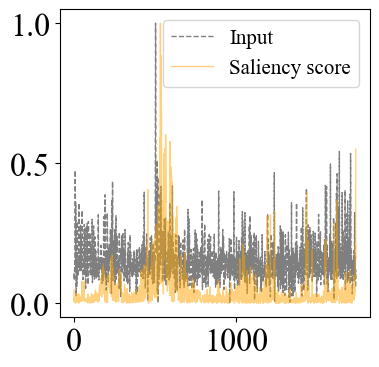

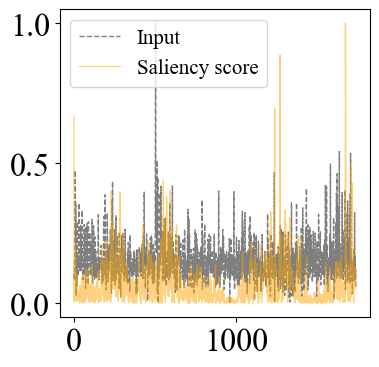

ZnSo4heptahydrate0.00167s20umsize50umconfocal600hzonly1spot.h5
(1, 1738)


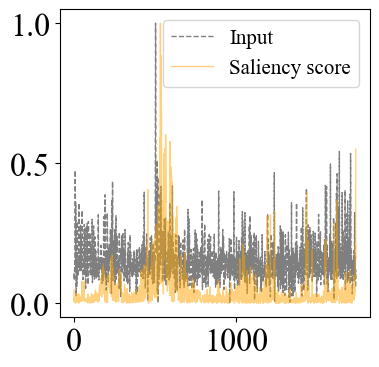

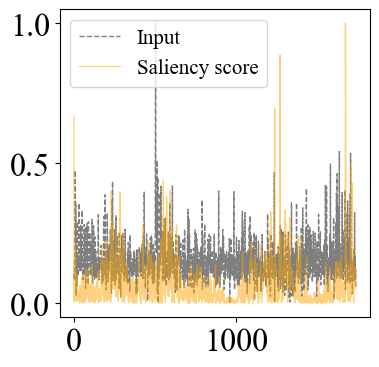

ZnSo4heptahydrate0.00174s20umsize50umconfocal575hz.h5
(1, 1738)


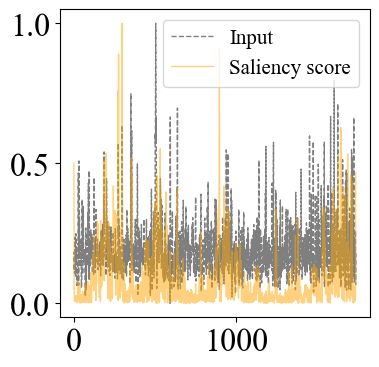

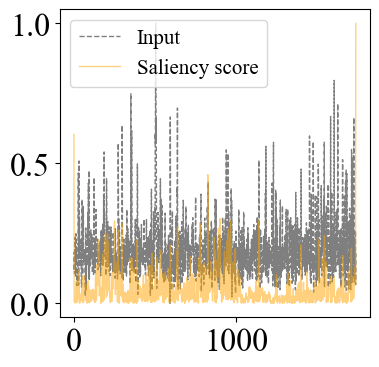

ZnSo4heptahydrate0.00190s20umsize50umconfocal525hz.h5
(1, 1738)


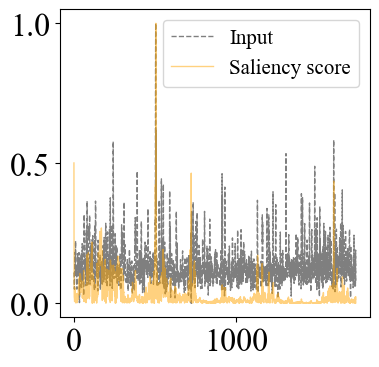

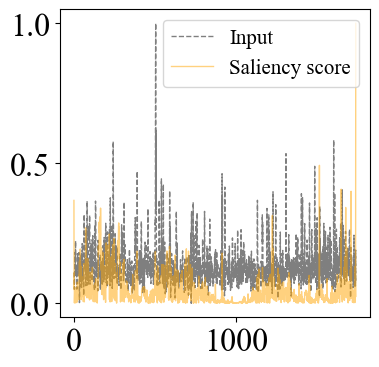

ZnSo4heptahydrate0.0025s20umsize50umconfocal400hz.h5
(1, 1738)


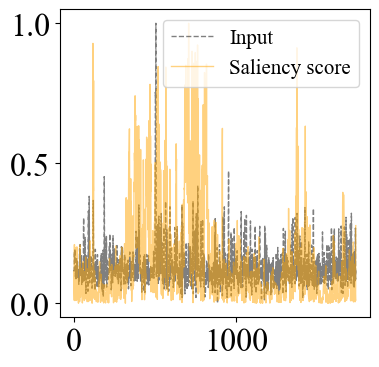

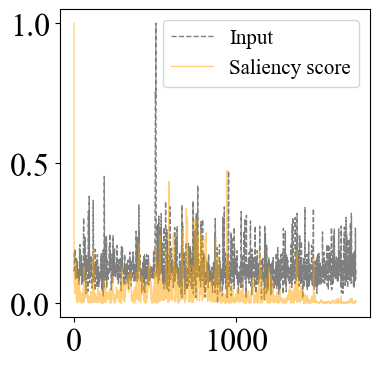

ZnSo4heptahydrate0.00286s20umsize50umconfocal350hz.h5
(1, 1738)


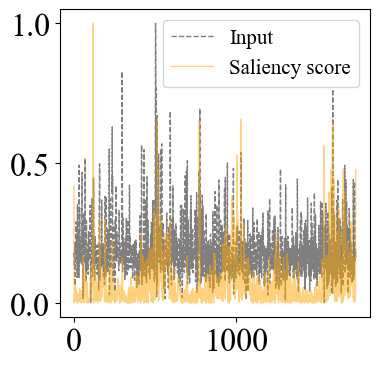

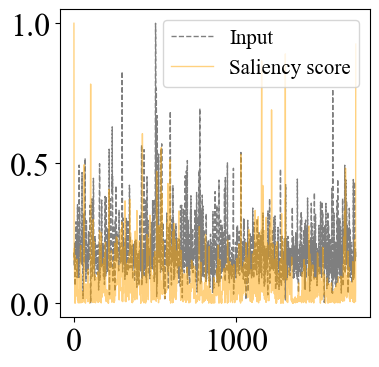

ZnSo4heptahydrate0.002s20umsize50umconfocal500hz.h5
(1, 1738)


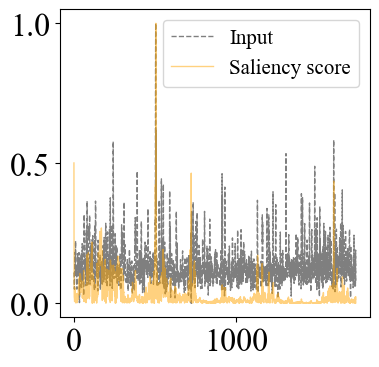

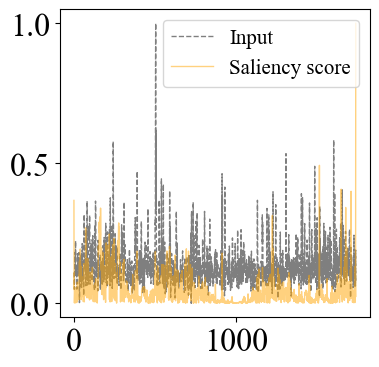

ZnSo4heptahydrate0.00333s20umsize50umconfocal300hz.h5
(1, 1738)


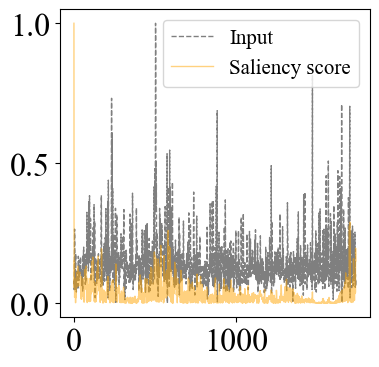

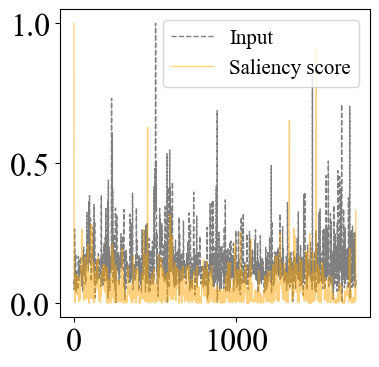

ZnSo4heptahydrate0.00417s20umsize50umconfocal240hz.h5
(1, 1738)


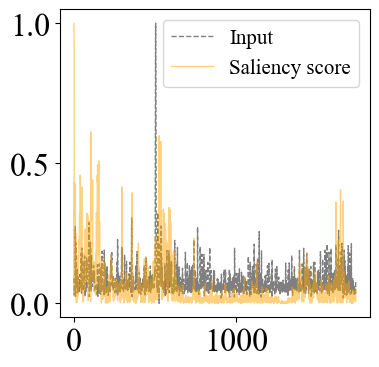

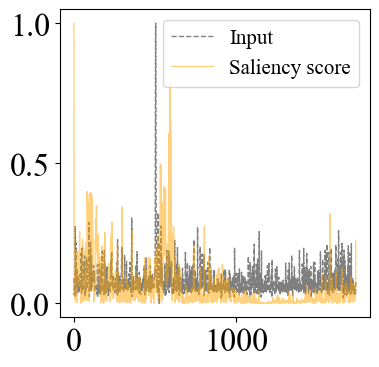

ZnSo4heptahydrate0.00455s20umsize50umconfocal220hz.h5
(1, 1738)


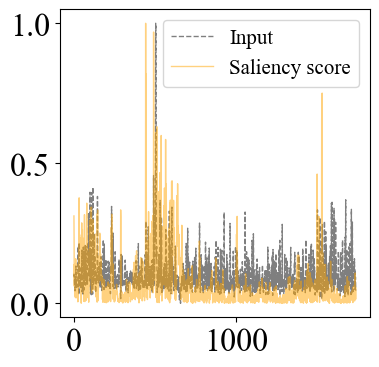

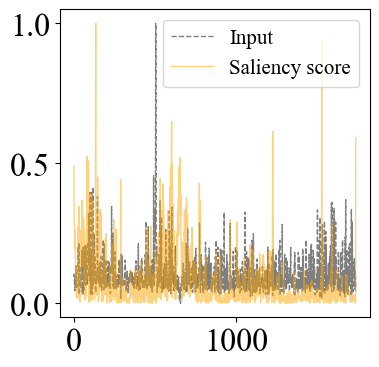

ZnSo4heptahydrate0.005s20umsize50umconfocal200hz.h5
(1, 1738)


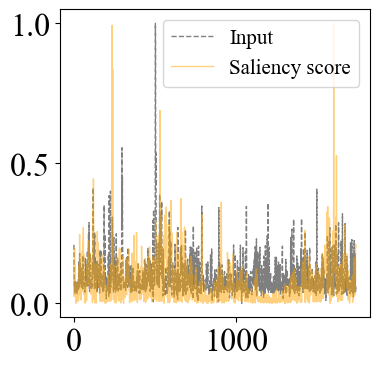

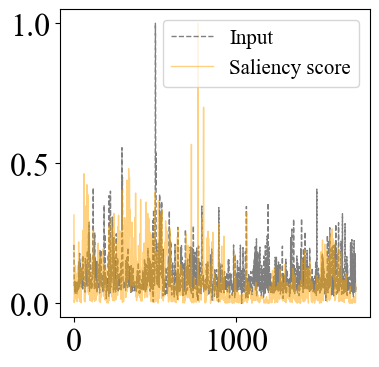

ZnSo4heptahydrate0.00625s20umsize50umconfocal160hz.h5
(1, 1738)


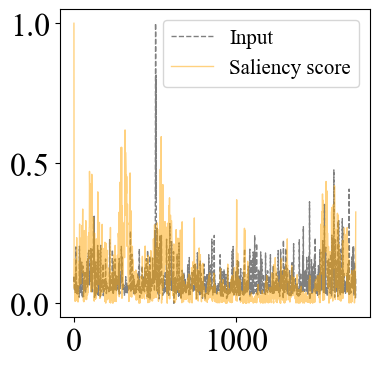

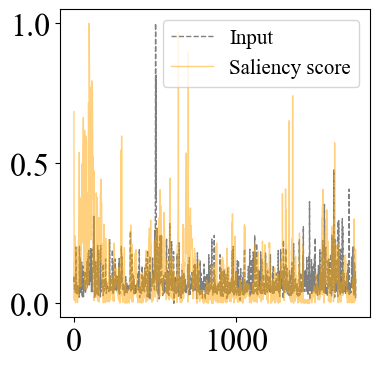

ZnSo4heptahydrate0.00714s20umsize50umconfocal140hz.h5
(1, 1738)


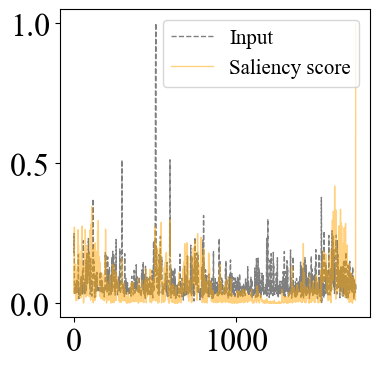

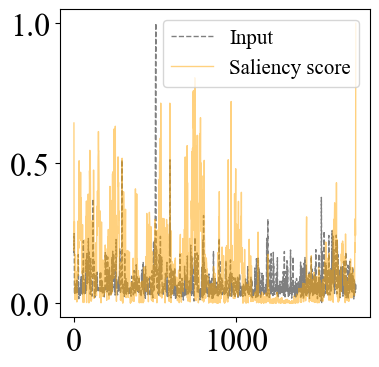

ZnSo4heptahydrate0.0125s20umsize50umconfocal80hz.h5
(1, 1738)


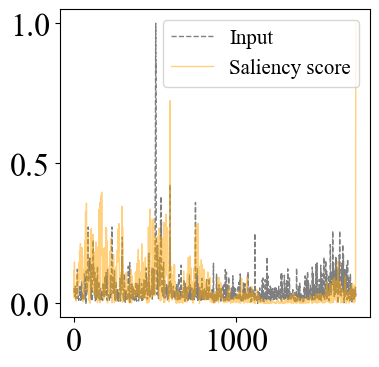

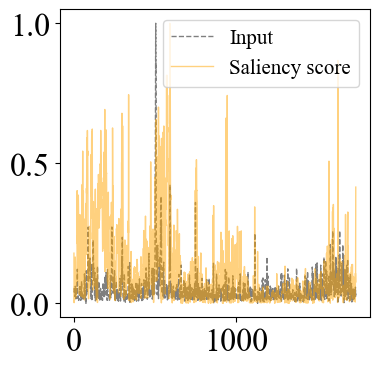

ZnSo4heptahydrate0.01667s20umsize50umconfocal60hz.h5
(1, 1738)


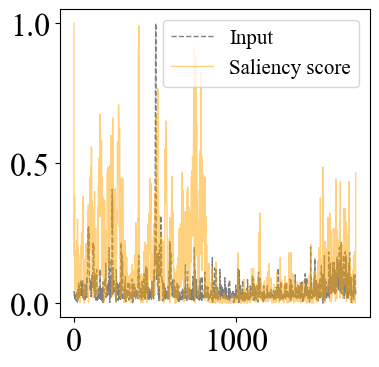

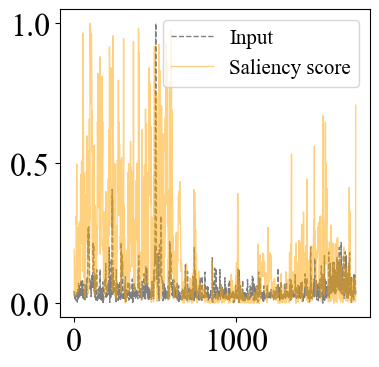

ZnSo4heptahydrate0.01s20umsize50umconfocal100hzredone2.h5
(1, 1738)


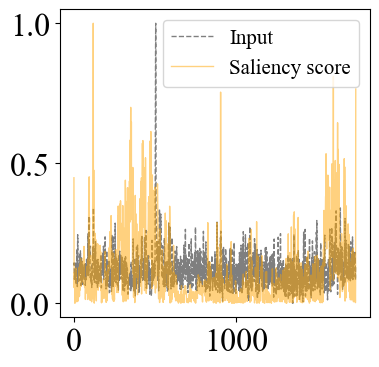

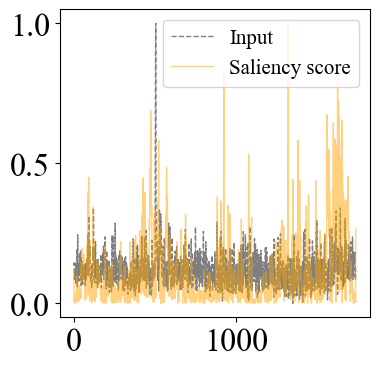

ZnSo4heptahydrate0.025s20umsize50umconfocal40hz.h5
(1, 1738)


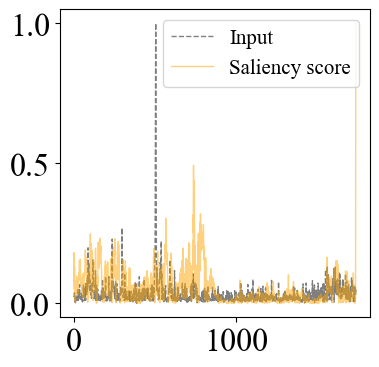

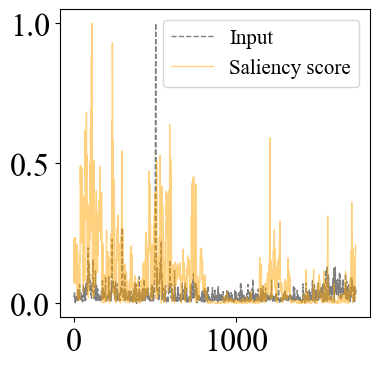

ZnSo4heptahydrate0.05s20umsize50umconfocal20hz.h5
(1, 1738)


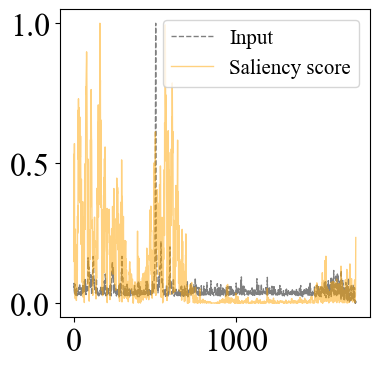

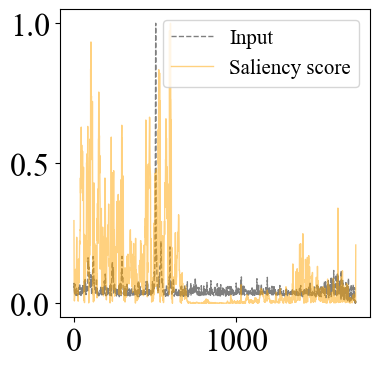

ZnSo4heptahydrate0.1s20umsize50umconfocal10hz.h5
(1, 1738)


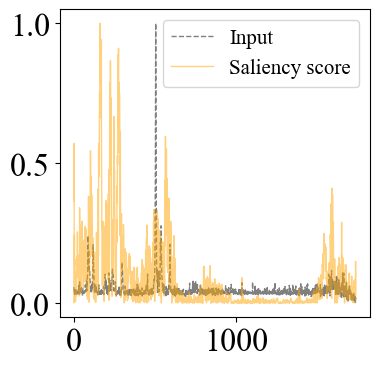

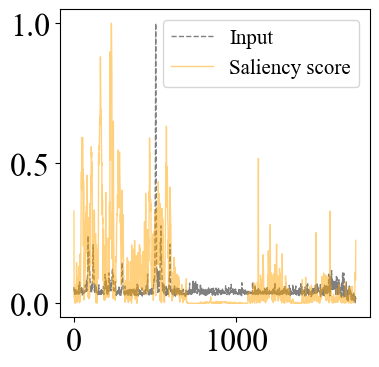

ZnSo4heptahydrate0.2s20umsize50umconfocal5hz.h5
(1, 1738)


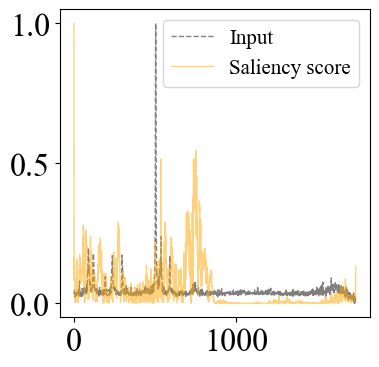

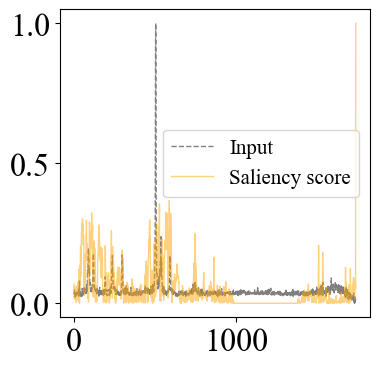

ZnSo4heptahydrate0.5s20umsize50umconfocal2hz.h5
(1, 1738)


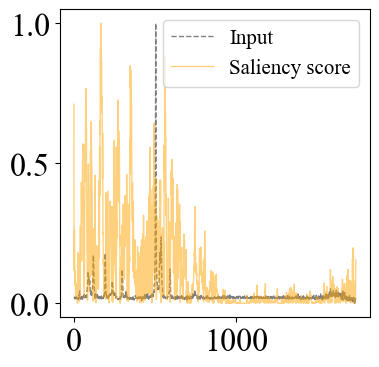

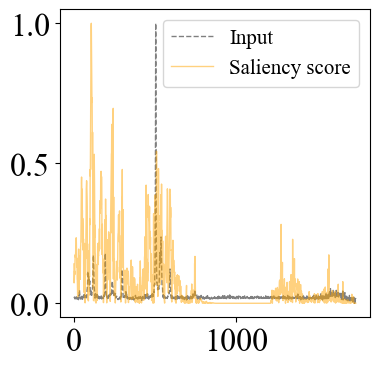

ZnSo4heptahydrate1s20umsize50umconfocal1hzredone.h5
(1, 1738)


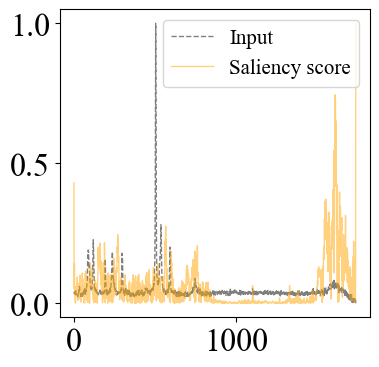

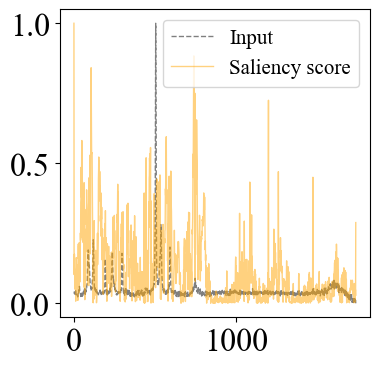

ZnSo4heptahydrate2s20umsize50umconfocal0.5hzredone.h5
(1, 1738)


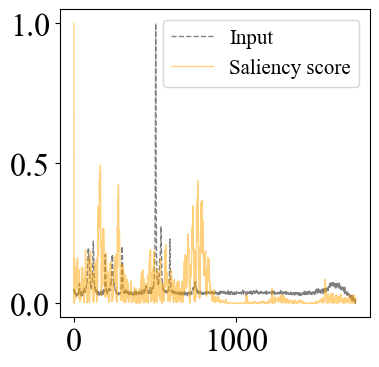

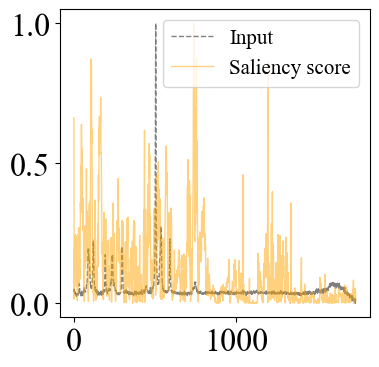

ZnSo4heptahydrate5s20umsize50umconfocal0.2hz.h5
(1, 1738)


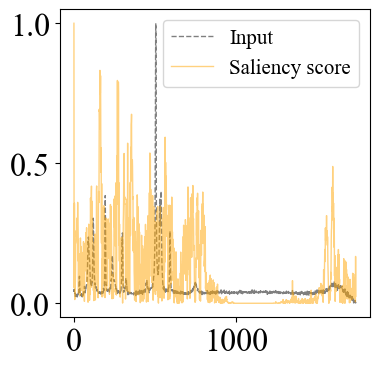

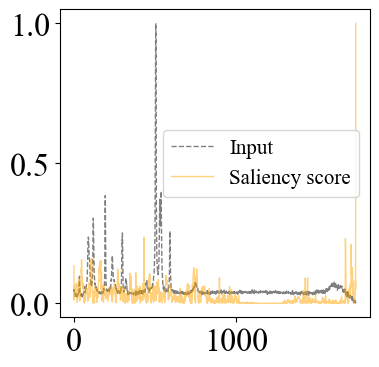

ZnSo4heptahydrate5s20umsize50umconfocal0.2hzonlyrightside.h5
(1, 1738)


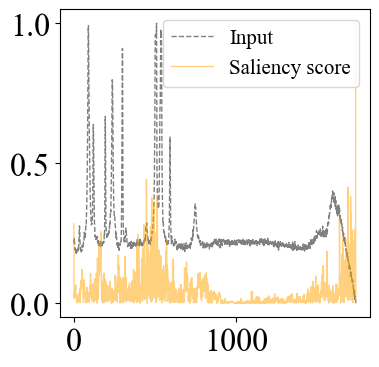

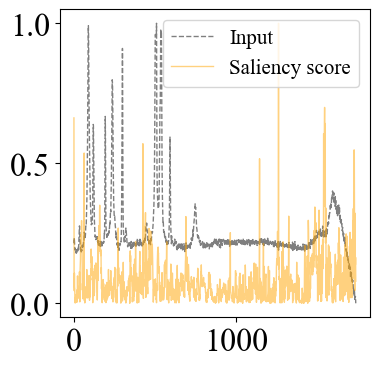

In [82]:
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"
for d, n in zip(data, data_names):
    print(n)
        
    dn = np.copy(d.reshape((-1, 1738)))

    dn = dn[np.sum(dn, axis = 1) != 0.0]

    inp = tf.constant(dn[:1])

    
    with tf.GradientTape() as tape:
        
        tape.watch(inp)
        result = ensemble_model(inp)[-1]

        grads = tape.gradient(result, inp)
        print(grads.numpy().shape)
        out = grads.numpy()
        out = np.abs(out/np.max(np.abs(out)))
        
        plt.figure(figsize=(4, 4))
        #plt.plot(np.mean(np.squeeze(out), axis = 0), alpha = 0.5, linewidth = 1)
        #plt.plot(np.mean(dn[:100], axis = 0), alpha = 0.5, linestyle = "--", linewidth = 1)
        plt.plot(dn[0], alpha = 0.5, linestyle = "--", linewidth = 1, color = "Black", label = "Input")
        plt.plot(np.squeeze(out), alpha = 0.5, linewidth = 1, color = "Orange", label = "Saliency score")
        
        plt.savefig("Figures/ZincSalMap_ensemble_" + n +".png", transparent = True,
                   bbox_inches='tight', pad_inches=0.75)
        plt.legend(fontsize = 15)
        plt.show()


    with tf.GradientTape() as tape:
        
        tape.watch(inp)
        result = standard_model(inp)[-1]

        grads = tape.gradient(result, inp)
        out = grads.numpy()
        out = np.abs(out/np.max(np.abs(out)))
        
        plt.figure(figsize=(4, 4))
        plt.plot(dn[0], alpha = 0.5, linestyle = "--", linewidth = 1, color = "Black", label = "Input")
        plt.plot(np.squeeze(out), alpha = 0.5, linewidth = 1, color = "Orange", label = "Saliency score")
        plt.savefig("Figures/ZincSalMap_standard_" + n +".png", transparent = True,
                   bbox_inches='tight', pad_inches=0.75)
        plt.legend(fontsize = 15)
        plt.show()
    
    